This notebook computes uniformity metrics for $ugr$ dropouts.

In [1]:
import rubin_sim.maf as maf
import matplotlib.pyplot as plt
from lbg_survey_metrics.metrics import map_number_density, map_pz_mean, map_pz_sig
import numpy as np
from lbg_survey_metrics.metric_plots import plot_map

In [2]:
# Load m5 maps
u5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_u.npz").metric_values
g5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_g.npz").metric_values
r5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_r.npz").metric_values
i5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_i.npz").metric_values
z5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_z.npz").metric_values

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


7730.447811316664


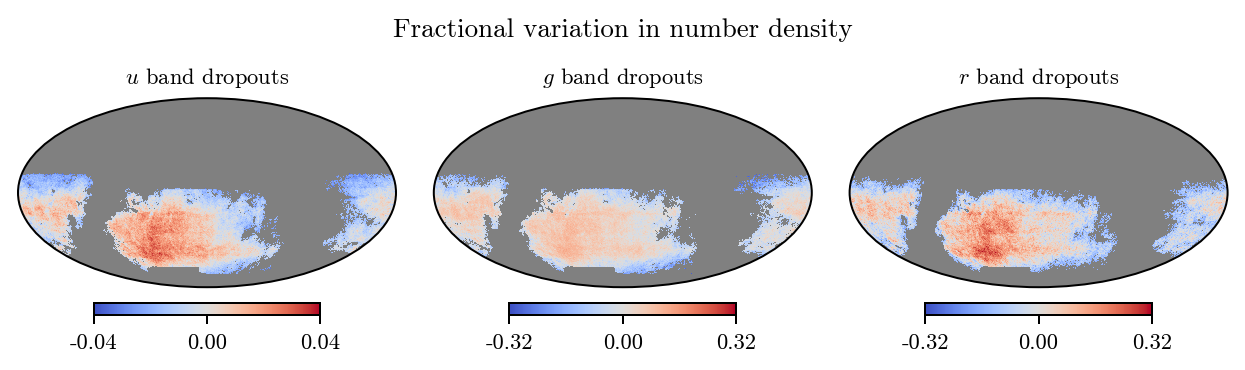

In [17]:
# Plot relative depth variations
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2), dpi=180)

# Set the title
fig.suptitle("Fractional variation in number density")

# u dropouts
n_u = map_number_density(u5, r5, "u")
rdn_u = (n_u - np.nanmean(n_u)) / np.nanmean(n_u)
plot_map(rdn_u, "$u$ band dropouts", sub=131)

# g dropouts
n_g = map_number_density(g5, i5, "g", dropout=1)
print(n_g.mean())
rdn_g = (n_g - np.nanmean(n_g)) / np.nanmean(n_g)
plot_map(rdn_g, "$g$ band dropouts", sub=132)

# r dropouts
n_r = map_number_density(r5, z5, "r", cut_on_drop=False)
rdn_r = (n_r - np.nanmean(n_r)) / np.nanmean(n_r)
plot_map(rdn_r, "$r$ band dropouts", sub=133)

# Hide axes
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

# Push axes closer together
plt.subplots_adjust(wspace=0.1)

In [4]:
rdn_g

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=nan)

In [5]:
import pymaster as nmt
import healpy as hp

In [6]:
(~rdn_g.mask).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
mask = nmt.mask_apodization((~rdn_g.mask).astype(int), 1.0, apotype="Smooth")
field = nmt.NmtField(mask, rdn_g.data[None, :])

In [8]:
mask * 0 + 1

array([1., 1., 1., ..., 1., 1., 1.])

In [9]:
b = nmt.NmtBin.from_nside_linear(128, 4)
ell_arr = b.get_effective_ells()
print(ell_arr.size)

95


0.03933992000411725


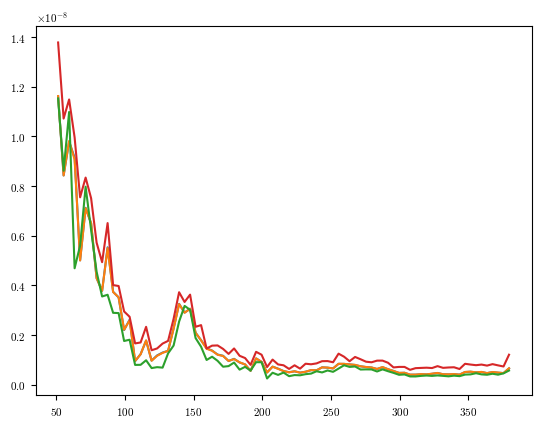

In [24]:
data = rdn_u
print(np.abs(data).max())

mask = nmt.mask_apodization((~data.mask).astype(int), 1.0, apotype="C1")
field = nmt.NmtField(mask, data.data[None, :])
cl = nmt.compute_full_master(field, field, b)
plt.plot(ell_arr[12:], cl[0][12:])

mask = nmt.mask_apodization((~data.mask).astype(int), 1.0, apotype="C2")
field = nmt.NmtField(mask, data.data[None, :])
cl = nmt.compute_full_master(field, field, b)
plt.plot(ell_arr[12:], cl[0][12:])

mask = nmt.mask_apodization((~data.mask).astype(int), 1.0, apotype="Smooth")
field = nmt.NmtField(mask, data.data[None, :])
cl = nmt.compute_full_master(field, field, b)
plt.plot(ell_arr[12:], cl[0][12:])

field = nmt.NmtField((~data.mask).astype(int), data.data[None, :])
cl = nmt.compute_full_master(field, field, b)
plt.plot(ell_arr[12:], cl[0][12:])

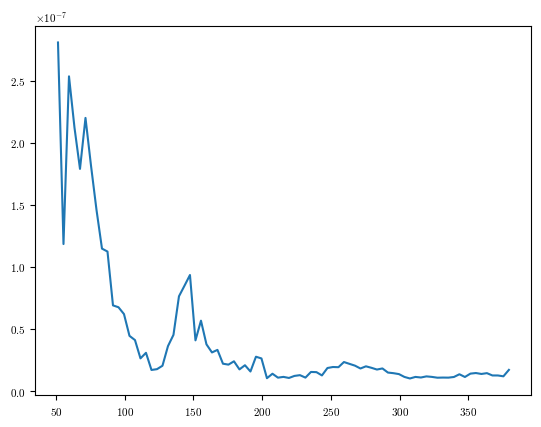

In [43]:
plt.plot(ell_arr[12:], cl[0][12:])

In [44]:
nmt.mask_apodization?

Signature: nmt.mask_apodization(mask_in, aposize, apotype='C1')
Docstring:
Apodizes a mask with an given apodization scale using different
methods. A given pixel is determined to be "masked" if its value is 0.
This method only works for HEALPix maps. Three apodization methods are
currently implemented:

- **"C1"** apodization: all pixels are multiplied by a factor :math:`f`       given by

  .. math::
    f=\left\{
    \begin{array}{cc}
        x-\sin(2\pi x)/(2\pi) & x<1\\
        1 & {\rm otherwise}
    \end{array}
    \right..

  where :math:`x=\sqrt{(1-\cos\theta)/(1-\cos\theta_*)}`, with
  :math:`\theta_*` the apodization scale, and :math:`\theta` the
  separation between a pixel and its nearest masked pixel (i.e. where
  the mask takes a zero value). See `Grain et al. 2009
  <https://arxiv.org/abs/0903.2350>`_.
- **"C2"** apodization: similar to "C1", but using the apodization
  function:

  .. math::
    f=\left\{
    \begin{array}{cc}
        \frac{1}{2}\left[1-\cos(\pi x)\righ